In [3]:
# DS776 Auto-Update (runs in ~2 seconds, only updates when needed)
# If this cell fails, see Lessons/Course_Tools/AUTO_UPDATE_SYSTEM.md for help
%run ../Course_Tools/auto_update_introdl.py

✅ introdl v1.6.37 already up to date


In [ ]:
# Import necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
import torch

# Use introdl's Trainer for smart caching with pretend_train
from introdl import (
    Trainer,
    get_device,
    wrap_print_text,
    config_paths_keys,
    show_session_spending
)

DEVICE = get_device()

# Import helper function for LLM classification
from Lesson_08_Helpers import llm_classifier

print = wrap_print_text(print)

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

# for just this lesson LESSON_DATA will point to the dataset we use throughout
LESSON_DATA = Path('./data').resolve() / 'IT_tickets_classify.csv'

✅ Environment: Unknown Environment | Course root: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776
   Using workspace: <DS776_ROOT_DIR>/home_workspace

📂 Storage Configuration:
   DATA_PATH: <DS776_ROOT_DIR>/home_workspace/data
   MODELS_PATH: /home/jbaggett/DS776_new/Lessons/Lesson_08_Text_Classification/Lesson_08_Models (local to this notebook)
   CACHE_PATH: <DS776_ROOT_DIR>/home_workspace/downloads
🔑 API keys: 9 loaded from home_workspace/api_keys.env
🔐 Available: ANTHROPIC_API_KEY, GEMINI_API_KEY, GOOGLE_API_KEY... (9 total)
✅ HuggingFace Hub: Logged in
✅ Loaded pricing for 340 OpenRouter models
✅ Cost tracking initialized ($9.39 credit remaining)
📦 introdl v1.6.37 ready



---

## 📌 Important: Using `Trainer` from `introdl`

**This notebook uses a special version of the HuggingFace `Trainer` class** that enables smart model caching, similar to how `train_network()` works in earlier lessons.

### Key Points:

1. **Import from `introdl`, not `transformers`:**
   ```python
   from introdl import Trainer  # ✓ Use this
   # NOT: from transformers import Trainer  # ✗ Don't use this
   ```

2. **Signature is identical to HuggingFace Trainer** except for one optional parameter:
   - `pretend_train=True` enables smart caching (just like `train_network`)
   - All other parameters work exactly the same as the standard HuggingFace Trainer

3. **How it works:**
   - **First run:** Trains the model and saves to `best_model/` directory
   - **Subsequent runs:** Loads the existing model instead of retraining
   - **Instructor models:** Automatically checks HuggingFace Hub for pre-trained models hosted by your instructor
   - **Priority:** HuggingFace Hub → Local `best_model/` → Train from scratch

4. **Benefits:**
   - Save time by not retraining models when re-running notebooks
   - Automatically use instructor-provided models in lessons
   - Use your own trained models in homework assignments

**This is the same smart caching behavior you're familiar with from `train_network()`!** Just set `pretend_train=True` when creating your Trainer, and it handles the rest automatically.

---


## Text Classification

**Note:**  It's important to read Chapter 2 in our NLP book in addition to this notebook.  Many things like tokenization and model architecture aren't discussed in the notebook.  

The field of text classification has been completely revolutionized since the invention of transformer models in 2017. Here's a tiny history of approaches to text classification.  If nothing else, read the headers and short descriptions. 

### **A Mini-History of Approaches for Text Classification**  

This timeline provides an overview of major advancements in text classification, from traditional machine learning models using Bag-of-Words and TF-IDF to modern transformer-based models like BERT and GPT.

---

### **Pre-2010s: Traditional ML with TF-IDF and Bag-of-Words**  
Before deep learning, text classification relied on statistical and machine learning approaches that used **Bag-of-Words (BoW)** and **TF-IDF** features. Popular classifiers included **Naïve Bayes, Support Vector Machines (SVMs), and Decision Trees**, which performed well despite ignoring word order and meaning.

- **1990s–Early 2000s**: Classical machine learning algorithms were widely used with simple BoW and TF-IDF feature representations.
- **2003–2010**: Topic modeling techniques like **Latent Semantic Analysis (LSA)** and **Latent Dirichlet Allocation (LDA)** emerged, helping with dimensionality reduction and improving classification performance.

---

### **2010s: Word Embeddings and Deep Learning**  
Fixed word embeddings, such as **Word2Vec** and **GloVe**, improved text representations by capturing word relationships in continuous vector spaces. Deep learning architectures like **CNNs and RNNs (LSTMs, GRUs)** further enhanced classification by learning sequential patterns in text.

- **2013**: **Word2Vec (Mikolov et al.)** introduced dense word embeddings, significantly improving text classification features over TF-IDF.
- **2014**: **GloVe (Pennington et al.)** refined word embeddings using word co-occurrence statistics, outperforming Word2Vec in some tasks.
- **2014–2015**: **CNNs for text classification** (e.g., Kim 2014) and **Recurrent Neural Networks (RNNs) with LSTMs/GRUs** became widely adopted.
- **2015–2016**: **Attention mechanisms** (Bahdanau et al. 2015) improved RNNs by helping models focus on important words in a sentence.

---

### **Late 2010s: Pretrained Contextual Embeddings and Transfer Learning**  
Contextual word embeddings and transformer architectures introduced a paradigm shift in text classification by learning rich, bidirectional word representations.

- **2018**: **ELMo (Peters et al.)** introduced deep contextualized embeddings, capturing word meaning based on sentence context.
- **2018**: **BERT (Devlin et al.)** revolutionized NLP by leveraging masked language modeling and bidirectional transformers to significantly improve classification accuracy.
- **2019**: **DistilBERT (Sanh et al.)** was introduced as a smaller, faster version of BERT, making transformer-based fine-tuning more efficient.

---

### **2020s: Transformer Fine-Tuning and Large Language Models (LLMs)**  
Modern NLP models rely on large-scale transformers trained on massive datasets. These models often perform well with minimal fine-tuning and even excel in zero-shot or few-shot classification tasks.

- **2020**: **RoBERTa (Liu et al.)**, **ALBERT (Lan et al.)**, and **XLNet (Yang et al.)** improved transformer-based models for classification by optimizing training techniques and model architecture.
- **2021–2023**: **GPT-3 and ChatGPT** demonstrated strong zero-shot and few-shot classification abilities, reducing the need for supervised fine-tuning.
- **2024–Present**: **LLMs like GPT-4 and fine-tuned versions (e.g., GPT-4-turbo, Mistral, Llama)** dominate text classification, often replacing traditional ML and deep learning approaches.

---

In this lesson we'll focus on the traditional MIL approach which can still work quite well, and the modern approaches using specialized transformer encoder models and LLMs.


## Classifying Technical Support Requests Example

In this notebook we'll demonstrate and compare three **practical** approaches for text classification.  As an example we'll classify technical support help requests into categories using a dataset downloaded from Kaggle.  Briefly, here are the three approaches we'll use:

1.  A **"pre-2010s" baseline technique** where statistical analysis of the help requests is used to create vectors containing information about the frequencies of words in the documents.  Those vectors are used as feature vectors for a typical machine learning classifier like logistic regression.

2. A **"2020s" industry standard** where we fine-tune a pre-trained transformer classification model.

3. A **modern LLM-based approach** with zero-shot and few-shot prompts.

Our goal is to build an automated classifier that can be used to send support tickets to appropriate technical support staff.


#### L08_1_IT_Tickets_Dataset Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_it_tickets_dataset/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_it_tickets_dataset/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/5QHjGH5l6rC" target="_blank">Open Descript version of video in new tab</a>

### Load and Visualize Data

This dataset is a public domain dataset found on Kaggle called ["IT Service Ticket Classification Dataset"](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset).  We'll included the csv file in the data subdirectory along in the same directory as this notebook.  

The data includes 47,837 help requests and their classifications into 8 categories: 'Hardware', 'HR Support', 'Access', 'Miscellaneous', 'Storage', 'Purchase', 'Internal Project', 'Administrative rights'.

Let's load the data and explore it a bit.



In [5]:
df = pd.read_csv(LESSON_DATA)

print(f'This dataset has {df.shape[0]} IT tickets')

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

This dataset has 47837 IT tickets


Print the first few rows to get a sense of the data:

In [6]:
df.head(10)

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous
5,mail please dear looks blacklisted receiving m...,Miscellaneous
6,prod servers tunneling prod tunneling va la tu...,Hardware
7,access request dear modules report report cost...,HR Support
8,reset passwords for our client and passwords c...,Access
9,direct reports missing time please action repo...,HR Support


Let's look at the distribution of the labels to geta sense of whether the dataset is balanced.  We can also see how long the help reequsts are.

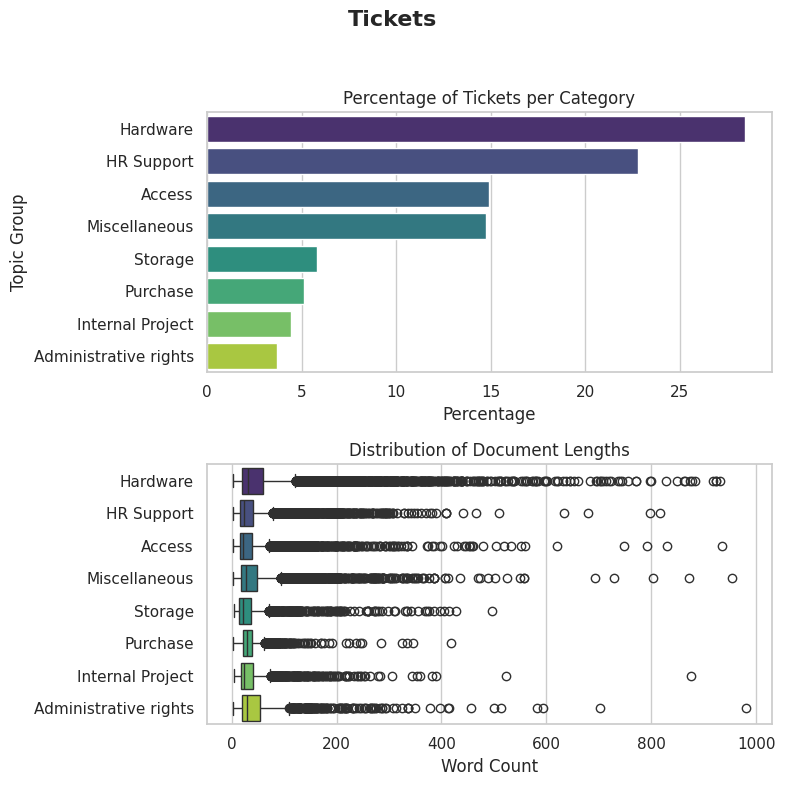

In [7]:
# Calculate percentages per category
category_counts = df["Topic_group"].value_counts(normalize=True) * 100
category_percentages = category_counts.reset_index()
category_percentages.columns = ["Topic_group", "Percentage"]

# Calculate lengths of documents as word count
df["Document_Length"] = df["Document"].apply(lambda x: len(x.split()))

# Get the order of categories from the barplot data
category_order = category_percentages["Topic_group"]

# Create a consistent color palette
palette = sns.color_palette("viridis", len(category_order))
color_mapping = dict(zip(category_order, palette))

# Create stacked plots
fig, axes = plt.subplots(2, 1, figsize=(8,8))

# Barplot: Percentage per category
sns.barplot(
    data=category_percentages,
    x="Percentage",
    y="Topic_group",
    palette=color_mapping,
    hue="Topic_group",
    order=category_order,
    ax=axes[0]
)
axes[0].set_title("Percentage of Tickets per Category")
axes[0].set_xlabel("Percentage")
axes[0].set_ylabel("Topic Group")

# Boxplot: Distribution of document lengths
sns.boxplot(
    data=df,
    x="Document_Length",
    y="Topic_group",
    palette=color_mapping,
    hue="Topic_group",
    order=category_order,
    ax=axes[1]
)
axes[1].set_title("Distribution of Document Lengths")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("")

# Set the suptitle
fig.suptitle("Tickets", fontsize=16, weight="bold")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The distribution of labels shows that the dataset is moderately imbalanced with a ration of the smallest class frequency to the largest class frequency of about 4:28 or 1:7.  We'll look at the classification report to see if imbalance is creating an issue.  

Nearly all of the help requests are about 100 words or less with only outliers having greater lengths.

### Prepare the data

Split the data and build mappings from text labels to integer labels and vice versa.

In [8]:
test_size=0.2
random_state=42

"""Split data into train and test sets of strings, and map labels to integer ids."""
train_texts_str, test_texts_str, train_labels_str, test_labels_str = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integer ids
# IMPORTANT: Sort labels for consistent ID mapping across runs (needed for pretrained models)
unique_labels = sorted(list(set(train_labels_str + test_labels_str)))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert labels to integer ids as lists
train_ids = [label_to_id[label] for label in train_labels_str]
test_ids = [label_to_id[label] for label in test_labels_str]



---

## Approach 1: Create Statistical Embedding Vectors and Apply Standard ML

#### L08_1_TFIDF_Plus_Logistic_Regression Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_tfidf_plus_logistic_regression/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_tfidf_plus_logistic_regression/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/CE1TdBdDw4s" target="_blank">Open Descript version of video in new tab</a>


We're going to create TF-IDF vectors to represent each help request.  Then we'll use those TF-IDF vectors to train and test a logistic regression classifier.

### What Are TF-IDF Vectors?

TF-IDF (Term Frequency-Inverse Document Frequency) vectors are a statistical representation of text data that capture the importance of terms within a document relative to a collection of documents (the corpus). This method assigns a weight to each term based on its frequency in a specific document (term frequency, TF) and how common or rare it is across all documents in the corpus (inverse document frequency, IDF). The result is a sparse, numerical vector for each document, where each dimension corresponds to a unique term in the vocabulary. TF-IDF is widely used in text mining, natural language processing, and machine learning as a feature extraction technique for tasks like classification, clustering, and information retrieval. However, as the size of the vocabulary grows, the dimensionality of the TF-IDF vectors increases, potentially leading to computational inefficiencies and the curse of dimensionality.

---

### Tricks for Limiting Dimensionality

To address the high dimensionality of TF-IDF vectors, several preprocessing techniques can be applied to reduce the vocabulary size while retaining the most meaningful terms. **Stemming** is one such method, where words are reduced to their root forms (e.g., "running" → "run"), grouping related words into a single term and thereby reducing the vocabulary size. Similarly, **lemmatization** refines this process by considering the context and part of speech to produce base forms. Removing **stopwords** like "the," "is," and "and" eliminates common, less informative terms that appear frequently across documents. Setting thresholds for **minimum and maximum document frequency** (e.g., `min_df` and `max_df`) ensures that terms appearing in very few documents or nearly all documents are excluded from the vocabulary. Additionally, limiting the vocabulary size directly with `max_features` retains only the top terms with the highest importance scores. Finally, incorporating **n-grams** (e.g., bigrams and trigrams) helps capture multi-word phrases, adding context while keeping the range limited to prevent explosive growth in dimensionality. Combining these techniques creates a more compact, computationally efficient representation of text data while preserving its semantic richness.

### Building the vectors

We'll use the TfidfVectorizer from sci-kit learn.  Here we're telling it to ignore common English stop words - words like "the", "end", "to" that carry little meaningful information on their own.  We're also telling the vectorizer to consider one-, two-, or three- word sequences (ngrams) as entries in the vocabulary so that "ball" and "big red ball" could be distinct.


In [9]:

tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common English stopwords
    min_df=2,  # Remove rare terms (appear in fewer than 2 documents)
    max_df=0.85,  # Remove overly common terms (appear in more than 85% of documents)
    max_features=1000,  # Limit vocabulary size to top 1000 terms
    ngram_range=(1, 3)  # Include unigrams, bigrams, and trigrams
)

# Fit the vectorizer and transform the input texts
train_features_tfidf = tfidf_vectorizer.fit_transform(train_texts_str)
test_features_tfidf = tfidf_vectorizer.transform(test_texts_str)

We can see below that the vectors for train_features are stored in a sparse array with 38,269 rows and 1000 columns.  Those 38,269 rows represent all help requests in teh training data.  The vectors have dimension 1000 because that's the size of the vocabulary we allowed.

In [10]:
train_features_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 873248 stored elements and shape (38269, 1000)>

Now we fit a logistic regression model using scikit-learn and make predictions for the test data.  We also produce a confusion matrix and a classification report.

Classification Report:
                       precision    recall  f1-score   support

               Access       0.92      0.87      0.89      1455
Administrative rights       0.84      0.70      0.76       342
           HR Support       0.84      0.83      0.84      2107
             Hardware       0.79      0.87      0.83      2760
     Internal Project       0.89      0.79      0.84       451
        Miscellaneous       0.80      0.82      0.81      1400
             Purchase       0.96      0.88      0.92       497
              Storage       0.92      0.85      0.89       556

             accuracy                           0.84      9568
            macro avg       0.87      0.82      0.85      9568
         weighted avg       0.85      0.84      0.84      9568



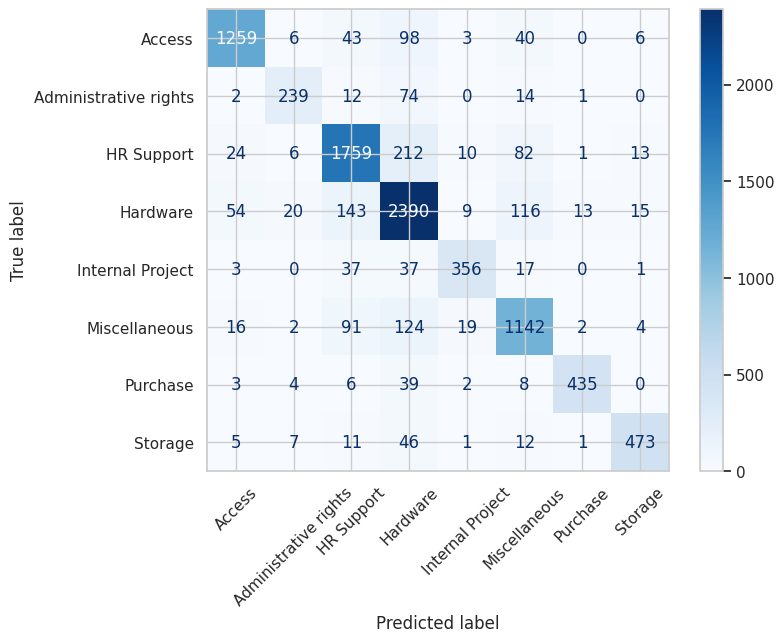

In [11]:
# Initialize and fit the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(train_features_tfidf, train_ids)

# Make predictions on the test set
test_predictions_id = model.predict(test_features_tfidf)

# Convert integer labels to string labels for the test set and predictions
test_predictions_str = [id_to_label[label] for label in test_predictions_id]

# Compute classification metrics
print("Classification Report:")
print(classification_report(test_labels_str, test_predictions_str))

# Compute and display the confusion matrix
cm = confusion_matrix(test_labels_str, test_predictions_str, labels=list(id_to_label.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()

# Create and return a DataFrame with test labels and predictions
results_df = pd.DataFrame({
    "Test Labels": test_labels_str,
    "Predictions": test_predictions_str
})

Overall, the model does well with 84% overall accuracy.  The smallest class, "Administrative Rights" is underpredicted.  The precision for that class is 84% suggesting the model is usually right when it predicts "Administrative Rights", but the recall is only 70% meaning that the model misses many instances of this class (it underpredicts).

We can try to correct for the imbalance in the date to see if how that changes the overall results.  A simple way to do that is to tell the logistic regression model to use balanced class weights to put more weight on the minority classes.

Classification Report:
                       precision    recall  f1-score   support

               Access       0.90      0.88      0.89      1455
Administrative rights       0.58      0.90      0.71       342
           HR Support       0.86      0.80      0.83      2107
             Hardware       0.86      0.75      0.80      2760
     Internal Project       0.76      0.93      0.84       451
        Miscellaneous       0.76      0.85      0.80      1400
             Purchase       0.88      0.91      0.90       497
              Storage       0.83      0.92      0.88       556

             accuracy                           0.83      9568
            macro avg       0.81      0.87      0.83      9568
         weighted avg       0.84      0.83      0.83      9568



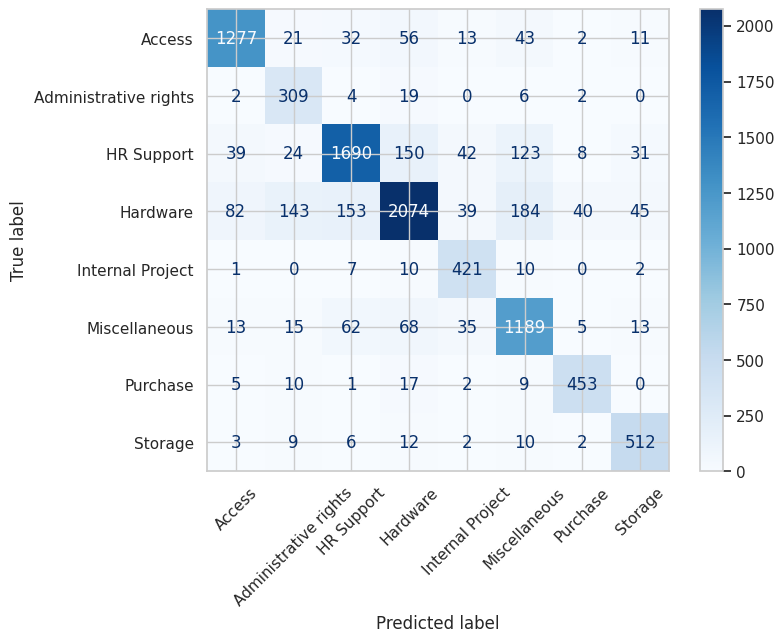

In [12]:
# Initialize and fit the logistic regression model
model = LogisticRegression(class_weight = 'balanced', max_iter=1000, random_state=42)
model.fit(train_features_tfidf, train_ids)

# Make predictions on the test set
test_predictions_id = model.predict(test_features_tfidf)

# Convert integer labels to string labels for the test set and predictions
test_predictions_str = [id_to_label[label] for label in test_predictions_id]

# Compute classification metrics
print("Classification Report:")
print(classification_report(test_labels_str, test_predictions_str))

# Compute and display the confusion matrix
cm = confusion_matrix(test_labels_str, test_predictions_str, labels=list(id_to_label.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()

# Create and return a DataFrame with test labels and predictions
results_df = pd.DataFrame({
    "Test Labels": test_labels_str,
    "Predictions": test_predictions_str
})

Now the overall accuracy is 83%.  In correcting for the imbalance in the data, the model is now overpredicting the minority "Administrative Rights" class.  You could choose one of those two models depending on which error is more tolerable, you could look for another way to address the data imbalance, or you could look for another modeling approach as we'll do in the next section.

---

## Approach 2: Using a Pretrained Model for the Same Task

Before we dive into fine-tuning our own model, let's explore an important real-world scenario: **What if someone has already trained a model for exactly the task we need?**

In many cases, you can find pretrained models on HuggingFace Hub that have been fine-tuned for specific tasks. This can save significant time and computational resources.

### The Model: `edna23/aits-bert-model`

This model was trained on an IT support ticket classification dataset (probably the same Kaggle dataset!) and classifies tickets into 8 categories:
- Hardware
- Access
- Miscellaneous
- HR Support
- Purchase
- Administrative rights
- Storage
- Internal Project

Let's see how to use this pretrained model in two ways:
1. **Using the Pipeline API** (simplest approach)
2. **Using the model and tokenizer directly** (more control)

### Method 1: Using the HuggingFace Pipeline API

The Pipeline API is the simplest way to use pretrained models. It handles tokenization, model inference, and post-processing automatically.

In [11]:
from transformers import pipeline

# Load the pretrained model using pipeline
# This automatically downloads the model and tokenizer
pretrained_classifier = pipeline(
    "text-classification",
    model="edna23/aits-bert-model"
)

# Test on a few examples
test_examples = [
    "My laptop screen is flickering and showing strange colors. Can someone help?",
    "I need to purchase 3 new monitors for our team. How do I submit a purchase order?",
    "Can you please give me admin access to the database server?",
    "My mailbox is full and I can't send emails anymore. Please increase my storage quota.",
    "We need to onboard a new employee starting Monday. Please create their account.",
]

print("Predictions using Pipeline API:")
print("=" * 80)
for text in test_examples:
    prediction = pretrained_classifier(text)[0]
    print(f"\nText: {text}")
    print(f"Predicted: {prediction['label']} (confidence: {prediction['score']:.4f})")

Predictions using Pipeline API:

Text: My laptop screen is flickering and showing strange colors. Can someone
help?
Predicted: Hardware (confidence: 0.9993)

Text: I need to purchase 3 new monitors for our team. How do I submit a purchase
order?
Predicted: Purchase (confidence: 0.9997)

Text: Can you please give me admin access to the database server?
Predicted: HR Support (confidence: 0.9942)

Text: My mailbox is full and I can't send emails anymore. Please increase my
storage quota.
Predicted: Storage (confidence: 0.9995)

Text: We need to onboard a new employee starting Monday. Please create their
account.
Predicted: Access (confidence: 0.9977)


### Method 2: Using the Model and Tokenizer Directly

For more control (e.g., batch processing, custom confidence thresholds), we can load the model and tokenizer separately:

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model and tokenizer
pretrained_model_name = "edna23/aits-bert-model"
pretrained_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
pretrained_model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name)
pretrained_model.to(DEVICE)

# Make predictions on the same test examples
print("\nDetailed Predictions using Model Directly:")
print("=" * 80)

for text in test_examples:
    # Tokenize
    inputs = pretrained_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to(DEVICE)

    # Get predictions
    with torch.no_grad():
        outputs = pretrained_model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)[0]
        predicted_class_id = torch.argmax(logits, dim=1).item()

    # Use model's built-in label mapping
    predicted_label = pretrained_model.config.id2label[predicted_class_id]
    confidence = probabilities[predicted_class_id].item()

    print(f"\nText: {text}")
    print(f"Predicted: {predicted_label} (confidence: {confidence:.4f})")

    # Show top 3 predictions
    top3_indices = torch.argsort(probabilities, descending=True)[:3]
    print("Top 3 predictions:")
    for idx in top3_indices:
        label = pretrained_model.config.id2label[idx.item()]
        prob = probabilities[idx].item()
        print(f"  {label}: {prob:.4f}")


Detailed Predictions using Model Directly:

Text: My laptop screen is flickering and showing strange colors. Can someone
help?
Predicted: Hardware (confidence: 0.9993)
Top 3 predictions:
  Hardware: 0.9993
  Purchase: 0.0002
  Miscellaneous: 0.0001

Text: I need to purchase 3 new monitors for our team. How do I submit a purchase
order?
Predicted: Purchase (confidence: 0.9997)
Top 3 predictions:
  Purchase: 0.9997
  Hardware: 0.0001
  Access: 0.0000

Text: Can you please give me admin access to the database server?
Predicted: HR Support (confidence: 0.9942)
Top 3 predictions:
  HR Support: 0.9942
  Hardware: 0.0047
  Miscellaneous: 0.0004

Text: My mailbox is full and I can't send emails anymore. Please increase my
storage quota.
Predicted: Storage (confidence: 0.9995)
Top 3 predictions:
  Storage: 0.9995
  Hardware: 0.0002
  HR Support: 0.0001

Text: We need to onboard a new employee starting Monday. Please create their
account.
Predicted: Access (confidence: 0.9977)
Top 3 predictions

### Evaluating the Pretrained Model on Our Test Set

Now let's evaluate this pretrained model on our full test set to see how it compares to our other approaches:

In [ ]:
# Make predictions on the full test set
print("\nMaking predictions on test set...")

pretrained_predictions_str = []
batch_size = 32

for i in range(0, len(test_texts_str), batch_size):
    batch_texts = test_texts_str[i:i+batch_size]

    # Tokenize batch
    inputs = pretrained_tokenizer(
        batch_texts,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to(DEVICE)

    # Get predictions
    with torch.no_grad():
        outputs = pretrained_model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

    # Convert IDs to labels using model's mapping
    batch_predictions = [pretrained_model.config.id2label[pred] for pred in predictions]
    pretrained_predictions_str.extend(batch_predictions)

print(f"✓ Generated {len(pretrained_predictions_str)} predictions")


Making predictions on test set...
✓ Generated 9568 predictions



Classification Report (Pretrained Model):
                       precision    recall  f1-score   support

               Access       0.97      0.98      0.97      1455
Administrative rights       0.95      0.94      0.94       342
           HR Support       0.95      0.97      0.96      2107
             Hardware       0.98      0.95      0.96      2760
     Internal Project       0.97      0.94      0.95       451
        Miscellaneous       0.94      0.97      0.96      1400
             Purchase       0.99      0.97      0.98       497
              Storage       0.98      0.92      0.95       556

             accuracy                           0.96      9568
            macro avg       0.96      0.96      0.96      9568
         weighted avg       0.96      0.96      0.96      9568



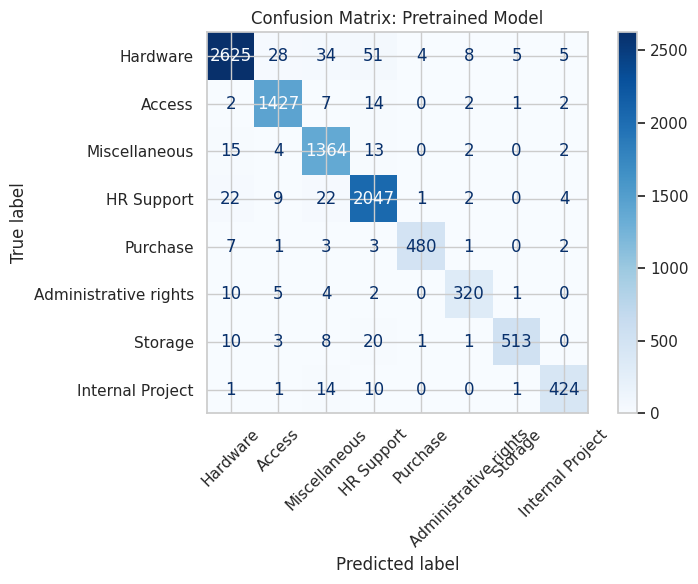

In [19]:
# Generate classification report
print("\nClassification Report (Pretrained Model):")
print("=" * 80)
print(classification_report(test_labels_str, pretrained_predictions_str))

# Compute confusion matrix
cm_pretrained = confusion_matrix(
    test_labels_str,
    pretrained_predictions_str,
    labels=list(pretrained_model.config.id2label.values())
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_pretrained,
    display_labels=list(pretrained_model.config.id2label.values())
)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.title("Confusion Matrix: Pretrained Model")
plt.tight_layout()
plt.show()

### Key Takeaways: Using Pretrained Models

**Advantages:**
- ✅ **Zero training time** - Model is ready to use immediately
- ✅ **No labeled data needed** - Can use models trained by others
- ✅ **Built-in label mappings** - Model knows its own categories via `model.config.id2label`
- ✅ **Easy to use** - Pipeline API makes it simple for quick prototyping

**Limitations:**
- ⚠️ **Fixed categories** - Can only classify into the labels the model was trained on
- ⚠️ **Data mismatch** - Performance depends on similarity between training data and your data
- ⚠️ **No customization** - Can't adapt to your specific dataset without fine-tuning

**When to use pretrained models:**
- Quick prototyping and proof-of-concept
- When labeled training data is limited or unavailable
- When the pretrained model's task closely matches yours
- When inference speed/cost is critical (no training overhead)

**When to fine-tune your own model (next approach):**
- When you need custom categories specific to your use case
- When you have sufficient labeled training data
- When maximum accuracy is critical and worth the training time
- When the pretrained model's performance is insufficient

---

## Approach 3: Fine-Tuning a Transformer Model Including a Classifier


#### L08_1_Transfomer_Fine-Tuning Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_transfomer_fine-tuning/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_transfomer_fine-tuning/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/Ego6IgU2Jnh" target="_blank">Open Descript version of video in new tab</a>



Now, instead of freezing the backbone and using it to extract features, we're going to add a newly initialized classification head and fine-tune the whole model for two epochs.  This allows the feature vectors to adapt to the dataset a little and for the classification head to leverage this information to improve the predictions.  We'll use a the same pretrained Distilbert model as in the previous section.

We include the data preparation again here for convenience:


In [13]:
# repeat of code from above for convenience

df = pd.read_csv(LESSON_DATA)

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

test_size=0.2
random_state=42

"""Split data into train and test sets of strings, and map labels to integer ids."""
train_texts_str, test_texts_str, train_labels_str, test_labels_str = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integer ids
# IMPORTANT: Sort labels for consistent ID mapping across training runs so pretend_train works correctly
unique_labels = sorted(list(set(train_labels_str + test_labels_str)))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert labels to integer ids as lists
train_ids = [label_to_id[label] for label in train_labels_str]
test_ids = [label_to_id[label] for label in test_labels_str]


Now we'll tokenize the dataset to prepare it for training.

In [14]:
# repeated from above for convenience

# Load Pre-trained Model and Tokenizer
model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Set a padding token (use an existing one or define a new one)
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))  # Adjust model embedding size

# Check for GPU
device = get_device()
print(f"Using device: {device}")

def tokenize_dataset(tokenizer, texts, labels):
    """Tokenize the dataset."""
    dataset = Dataset.from_dict({"text": texts, "label": labels})
    tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True)
    return tokenized_dataset

# Tokenize datasets
train_tokenized = tokenize_dataset(tokenizer, train_texts_str, train_ids)
test_tokenized = tokenize_dataset(tokenizer, test_texts_str, test_ids)

Using device: cuda


Map:   0%|          | 0/38269 [00:00<?, ? examples/s]

Map:   0%|          | 0/9568 [00:00<?, ? examples/s]

Finally, we can fine-tune the model.  Two epochs was enough here.  Adding a third didn't improve significantly.
The fine-tuning took about 3 minutes on a high-end NVIDIA gaming GPU.  You'll work with a smaller dataset in the homework.

In [15]:
batch_size = 32  # Reduce if memory issues

models_and_logs_dir = MODELS_PATH / 'L08_fine_tune_distilbert'

# Include label2id and id2label mappings so the model knows actual label names
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_to_id), label2id=label_to_id, id2label=id_to_label)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=models_and_logs_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01, # Regularization to prevent overfitting
    bf16=True,  # Automatically uses BF16 if GPU supports it (lower precision for speed and memory)
    logging_dir=models_and_logs_dir / "logs",
    load_best_model_at_end=True, # Load the best model at the end of training
    metric_for_best_model="eval_accuracy",
    save_total_limit=1, # Keep only the best model
    logging_strategy="epoch",
    disable_tqdm=False # should default to False, but seems necessary to set to False to see progress bar
)

def compute_metrics(pred):
    """Compute evaluation metrics."""
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"eval_accuracy": acc, "eval_f1": f1, "eval_precision": precision, "eval_recall": recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    pretend_train=True,  # Enable smart caching - loads existing model if available
)

output = trainer.train()


✓ Checking HuggingFace Hub: hobbes99/DS776-models/L08_fine_tune_distilbert
✓ Model cached locally to: Lesson_08_Models/L08_fine_tune_distilbert/best_model
Model already trained. Loading checkpoint...



Loading:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Training History:


,epoch,train_loss,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
0,1,0.5665,0.4201,0.8608,0.8616,0.8671,0.8608
1,2,0.2464,0.3553,0.8837,0.8835,0.8838,0.8837



✓ Best model: Epoch 2 | Accuracy: 0.8837


Now we'll make predictions with our newly fine-tuned model and build a classification report.

In [16]:
predictions = trainer.predict(test_tokenized)

y_true_id = predictions.label_ids
y_pred_id = np.argmax(predictions.predictions, axis=1)

test_labels_str = [id_to_label[label] for label in y_true_id]
predictions_str = [id_to_label[label] for label in y_pred_id]

print("Classification Report:")
print(classification_report(y_true_id, y_pred_id, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

               Access       0.91      0.93      0.92      1455
Administrative rights       0.87      0.78      0.82       342
           HR Support       0.88      0.89      0.88      2107
             Hardware       0.88      0.87      0.87      2760
     Internal Project       0.89      0.87      0.88       451
        Miscellaneous       0.85      0.87      0.86      1400
             Purchase       0.95      0.90      0.92       497
              Storage       0.89      0.92      0.91       556

             accuracy                           0.88      9568
            macro avg       0.89      0.88      0.88      9568
         weighted avg       0.88      0.88      0.88      9568



We can see that the overall accuracy has improved to about 89%.  Moreover, the imbalanced data seems to be less of an issue since the precision and recall for the smallest and largest classes are more similar than they were before.  The model does seem to be underpredicting Administrative Rights a little, but is still improved over the previous models.  It may continue to improve by fine-tuning for another epoch or two.

Let's have a quick look at the confusion matrix:

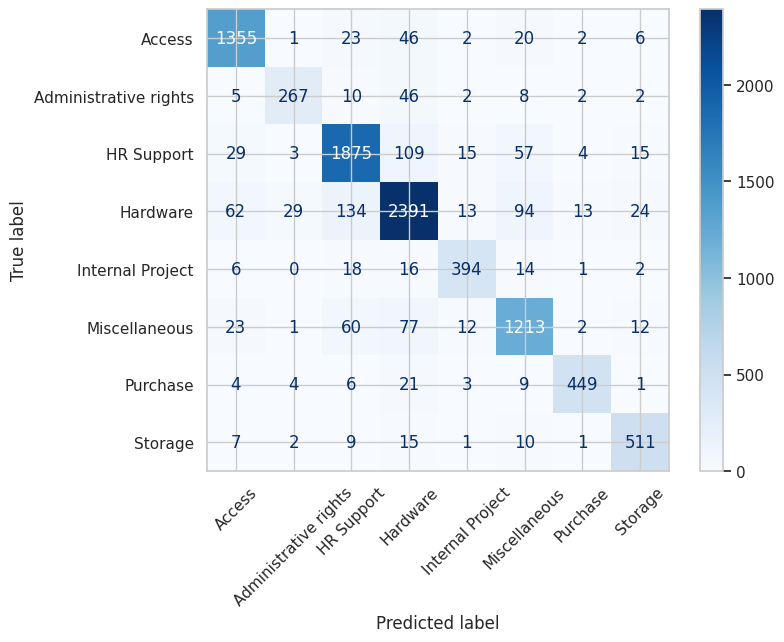

In [17]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels_str, predictions_str, labels=list(id_to_label.values()))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()


### Loading a Pretrained Model for Inference

One of the most important skills in deep learning is knowing how to load and use a trained model for making predictions on new data. This is essential for:
- Deploying models in production applications
- Making predictions across multiple sessions without retraining
- Sharing models with others (via HuggingFace Hub or local files)
- Testing model performance on new datasets

We'll demonstrate **two approaches** for using our fine-tuned model:

1. **Using Pipeline API** (simplest - recommended for quick inference)
2. **Manual Loading** (more control - recommended for production/batch processing)

Both methods work with the model we just trained and saved in `best_model/`.

#### Method 1: Using the Pipeline API (Simplest)

The HuggingFace `pipeline` API is the easiest way to use a trained model. It automatically handles:
- Loading the model and tokenizer
- Preprocessing inputs (tokenization)
- Running inference
- Post-processing outputs (converting logits to predictions)

**Best for:** Quick testing, prototypes, interactive use

In [18]:
from transformers import pipeline

# Load our fine-tuned model using pipeline
# This automatically loads both the model and tokenizer
best_model_path = models_and_logs_dir / "best_model"

classifier_pipeline = pipeline(
    "text-classification",
    model=str(best_model_path),
    device=DEVICE
)

print(f"✓ Pipeline loaded from: {best_model_path}")
print(f"✓ Model knows {len(classifier_pipeline.model.config.id2label)} categories")

# Create some new example support requests to classify
new_support_requests = [
    "My laptop screen is flickering and showing strange colors. Can someone help?",
    "I need to purchase 3 new monitors for our team. How do I submit a purchase order?",
    "Can you please give me admin access to the database server?",
    "My mailbox is full and I can't send emails anymore. Please increase my storage quota.",
    "We need to onboard a new employee starting Monday. Please create their account.",
]

print("Making predictions with Pipeline API:")
print("=" * 80,"\n")

# Use pipeline for batch predictions (pass the whole list)
# Pipeline automatically handles batching for efficiency
results = classifier_pipeline(new_support_requests)

# Display results
for request, result in zip(new_support_requests, results):
    label = result["label"]
    confidence = result["score"]
    
    print(f"Request: {request}")
    print(f"Predicted: {label} (confidence: {confidence:.4f})")
    print("-" * 80,"\n")

✓ Pipeline loaded from: /home/jbaggett/DS776_new/Lessons/Lesson_08_Text_Classifi
cation/Lesson_08_Models/L08_fine_tune_distilbert/best_model
✓ Model knows 8 categories
Making predictions with Pipeline API:

Request: My laptop screen is flickering and showing strange colors. Can someone
help?
Predicted: Hardware (confidence: 0.9958)
--------------------------------------------------------------------------------

Request: I need to purchase 3 new monitors for our team. How do I submit a
purchase order?
Predicted: Purchase (confidence: 0.9954)
--------------------------------------------------------------------------------

Request: Can you please give me admin access to the database server?
Predicted: Hardware (confidence: 0.5232)
--------------------------------------------------------------------------------

Request: My mailbox is full and I can't send emails anymore. Please increase my
storage quota.
Predicted: Storage (confidence: 0.9960)
-------------------------------------------

#### Method 2: Manual Loading (More Control)

For production applications or when you need more control (controlled batch processing, custom thresholds, confidence scores for all classes), you can load the model and tokenizer separately.

**Best for:** Production deployments, batch processing, custom post-processing

In [19]:
# Step 1: Load the fine-tuned model and tokenizer separately
best_model_path = models_and_logs_dir / "best_model"

print(f"Loading model from: {best_model_path}")
loaded_model = AutoModelForSequenceClassification.from_pretrained(best_model_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(best_model_path)
loaded_model.to(device)
loaded_model.eval()  # Set to evaluation mode
print("✓ Model and tokenizer loaded successfully!\n")

# Step 2: Make predictions manually
print("Making predictions with Manual Loading:")
print("=" * 80,"\n")

for request in new_support_requests:
    # Tokenize input
    inputs = loaded_tokenizer(
        request,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to(device)

    # Get predictions
    with torch.no_grad():
        outputs = loaded_model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()

    # Use model's built-in label mapping
    predicted_label = loaded_model.config.id2label[predicted_class_id]

    # Get confidence score
    probabilities = torch.nn.functional.softmax(logits, dim=1)[0]
    confidence = probabilities[predicted_class_id].item()

    print(f"Request: {request}")
    print(f"Predicted: {predicted_label} (confidence: {confidence:.4f})")
    print("-" * 80,"\n")

Loading model from: /home/jbaggett/DS776_new/Lessons/Lesson_08_Text_Classificati
on/Lesson_08_Models/L08_fine_tune_distilbert/best_model
✓ Model and tokenizer loaded successfully!

Making predictions with Manual Loading:

Request: My laptop screen is flickering and showing strange colors. Can someone
help?
Predicted: Hardware (confidence: 0.9958)
--------------------------------------------------------------------------------

Request: I need to purchase 3 new monitors for our team. How do I submit a
purchase order?
Predicted: Purchase (confidence: 0.9954)
--------------------------------------------------------------------------------

Request: Can you please give me admin access to the database server?
Predicted: Hardware (confidence: 0.5232)
--------------------------------------------------------------------------------

Request: My mailbox is full and I can't send emails anymore. Please increase my
storage quota.
Predicted: Storage (confidence: 0.9960)
----------------------------

### When to Use Each Approach

**Use Pipeline API when:**
- ✅ You want the simplest possible code
- ✅ You're prototyping or testing interactively
- ✅ Default preprocessing is sufficient
- ✅ You want automatic batching (pipeline handles this for you)
- ✅ You need top-k predictions (use `top_k` parameter)

**Use Manual Loading when:**
- ✅ You need ALL confidence scores for all classes (not just top-k)
- ✅ You need custom preprocessing or post-processing
- ✅ You're deploying in production and need fine-grained control
- ✅ You want to implement custom decision thresholds
- ✅ You need to extract intermediate layer outputs or embeddings
- ✅ You need very precise control over batch size and memory usage

**Performance:** Both methods use the same model and will give identical predictions. Pipeline API automatically handles batching when you pass a list of texts, making it efficient for most use cases.

**Pipeline flexibility:**
```python
# Single document, top prediction
result = classifier_pipeline("My laptop is broken")

# Batch of documents (automatically batched)
results = classifier_pipeline(["Request 1", "Request 2", "Request 3"])

# Get top-3 predictions with confidence scores
top3 = classifier_pipeline("My laptop is broken", top_k=3)
# Returns: [{label: "Hardware", score: 0.95}, {label: "Purchase", score: 0.03}, ...]

# Get ALL predictions (set top_k=None)
all_predictions = classifier_pipeline("My laptop is broken", top_k=None)
```

**Bottom line:** Pipeline API is powerful enough for most use cases. Only use manual loading when you need very specific control or access to model internals.

---

## Approach 4: Use an LLM and prompting for Classification


#### L08_1_LLM_Classification Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_llm_classification/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l08_1_llm_classification/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/WY8FXinVXAz" target="_blank">Open Descript version of video in new tab</a>



Here we'll demonstrate how to use an LLM with zero-shot prompting.  Zero-shot means we're not providing any classification examples in our prompt.  Instead, we specify the possible labels and additional instructions and let the an LLM try to sort it out!

We wouldn't normally use an LLM here since we have plenty of data for fine-tuning, but let's see what an LLM can do as an example.

We'll first use one of our local models, but you could substitute an open-source model from Groq or Together.AI here if you like.

In [20]:
# For this lesson, we'll use OpenRouter models with llm_generate()
# Some recommended models for classification tasks:
# - 'gemini-flash-lite' - Fast, cost-effective (Google)
# - 'gpt-4o-mini' - Good balance of speed and quality (OpenAI)
# - 'llama-3.3-70b' - Strong open-source model (Meta)
# - 'mistral-medium' - Balanced performance (Mistral)

# We'll start with Gemini Flash Lite for its speed and low cost
LLM_MODEL = 'gemini-flash-lite'
print(f"Using model: {LLM_MODEL}")

Using model: gemini-flash-lite


We've built a helper function for using our selected LLM as a classifier.  We'll talk about it a bit in our video and show how to use it via an example.

## Understanding the `llm_classifier()` Helper Function

We've created a helper function `llm_classifier()` (imported from `Lesson_08_Helpers.py`) that simplifies using LLMs for classification tasks. Let's look at how it works:

### **The Code**

```python
def llm_classifier(model_name, texts, system_prompt, prompt_template, 
                   temperature=0, estimate_cost=False, **kwargs):
    """
    Classify text using a Large Language Model (LLM).
    
    Returns:
        list of str: Predicted labels for the input texts.
    """
    # Step 1: Build individual prompts for each text
    user_prompts = [prompt_template.format(text=text) for text in texts]
    
    # Step 2: Send all prompts to the LLM via llm_generate()
    predicted_labels = llm_generate(
        model_name,
        user_prompts,
        system_prompt=system_prompt,
        temperature=temperature,
        estimate_cost=estimate_cost,
        **kwargs
    )
    
    # Step 3: Return the predicted labels
    return predicted_labels
```

### **How It Works**

1. **Builds User Prompts**: Takes your `prompt_template` (which contains a `{text}` placeholder) and creates a separate prompt for each document you want to classify.

   For example, if your template is:
   ```
   "Classify this support request: {text}\nPredicted Label:"
   ```
   
   And you have 100 support requests, it creates 100 prompts like:
   ```
   "Classify this support request: My laptop screen is flickering...\nPredicted Label:"
   "Classify this support request: I need to purchase monitors...\nPredicted Label:"
   ... (98 more)
   ```

2. **Calls `llm_generate()`**: Sends all the prompts to the LLM. The `llm_generate()` function (from `introdl`) handles:
   - API communication with OpenRouter
   - Batching requests efficiently
   - Cost tracking and estimation
   - Returning the LLM's text responses

3. **Extracts Classifications**: The LLM returns text responses for each prompt. If your prompt is well-designed, the response should be just the label name (e.g., "Hardware", "Purchase", "Storage").

   These responses become your predicted labels.

### **Key Parameters**

- **`model_name`**: Which LLM to use (e.g., `'gemini-flash-lite'`, `'gpt-4o-mini'`)
- **`texts`**: List of documents to classify
- **`system_prompt`**: Instructions for the LLM (e.g., "You are an expert IT support classifier")
- **`prompt_template`**: Template with `{text}` placeholder for building prompts
- **`temperature`**: 0 for deterministic (consistent predictions), higher for creativity
- **`estimate_cost`**: `True` to see API cost estimates before running

### **Why This Approach?**

This helper function makes LLM classification simple:
- You don't need to write API calls manually
- Handles batching and efficiency automatically
- Works with any OpenRouter model (or other OpenAI-compatible APIs)
- Integrates with `introdl`'s cost tracking

The **challenge** with LLM classification is getting the model to output **exactly** the labels you want. As you'll see in the examples below, even with detailed prompts, LLMs sometimes output variations or additional text. This is why prompt engineering is crucial!

### Quick Demonstration

**Note:**  It cost $0.21 in OpenRouter credit the last time I ran all the cells in this notebook.  

Before diving into the full classification task, let's see a minimal example of how `llm_classifier` works:

In [21]:
# Quick demonstration of how llm_classifier works
demo_texts = [
    "My laptop won't turn on",
    "I need to buy a new keyboard"
]

demo_system = "You are an IT classifier."
demo_template = "Classify as Hardware or Purchase: {text}\nLabel:"

# This will send 2 prompts to the LLM and get 2 labels back
demo_predictions = llm_classifier(
    'gemini-flash-lite',
    demo_texts,
    demo_system,
    demo_template
)

for text, label in zip(demo_texts, demo_predictions):
    print(f"Text: {text}")
    print(f"Predicted: {label}\n")

Text: My laptop won't turn on
Predicted: Hardware

Text: I need to buy a new keyboard
Predicted: Purchase



In [22]:
# repeat of code from above for convenience

df = pd.read_csv(LESSON_DATA)

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

test_size=0.2
random_state=42

"""Split data into train and test sets of strings, and map labels to integer ids."""
train_texts_str, test_texts_str, train_labels_str, test_labels_str = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integer ids
unique_labels = sorted(list(set(train_labels_str + test_labels_str)))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert labels to integer ids as lists
train_ids = [label_to_id[label] for label in train_labels_str]
test_ids = [label_to_id[label] for label in test_labels_str]


It's a good idea to experiment with a small number of examples to refine your prompts.  It can be difficult to get an LLM to produce the exact output you want so you often need to be very directed in your prompts. 

In the next cell we try to classify the first 10 requests in the test set.  (I spent a while playing here to try to get the LLM to produce only the desired labels.  You'll see in the next cell that it's far from good at this.)

In [23]:
N = 10
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """Using only the labels: 
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.
Classify the following support request using exactly one of the labels.  
Do not use any other labels.
You must return only the label with nothing else.
If you are unsure, choose Miscellaneous.
Support Request: {text}, Predicted Label:"""

# Use OpenRouter with Gemini Flash Lite (fast and cost-effective)
predictions = llm_classifier(LLM_MODEL, texts, system_prompt, prompt_template)

for i in range(N):
    print(f"Support Request: {texts[i]}\n")
    print(f"Predicted Label: {predictions[i]}, Actual Label: {labels[i]}")
    print("-----------------------------------------------\n")

Support Request: issue with server process sent tuesday issue with server
process hi could you please help with following issue getting once few minutes
discipline lead

Predicted Label: Miscellaneous, Actual Label: Hardware
-----------------------------------------------

Support Request: new purchase po wednesday february purchase po dear purchased
please log installation please take consideration mandatory receipts section
order receive item ordered kind regards administrator information

Predicted Label: Purchase, Actual Label: Purchase
-----------------------------------------------

Support Request: oracle pas urgent re we updated rights query hi can get some
assistance here looks like have full control for codes only one working for
cannot forecast need done by friday thanks programme portfolio officer mobile
phone

Predicted Label: Access, Actual Label: Hardware
-----------------------------------------------

Support Request: new starter access thursday pm re starter form hell

Now let's apply the LLM to 100 examples to compile some statistics about its performance. Since we're using such a small subset the statistics won't be very precise, but they'll be enough to get an idea about this approach.  First we'll show with the 'gemini-flash-lite' model.

In [24]:
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """Using only the labels: 
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.
Classify the following support request using exactly one of the labels.  
Do not use any other labels.
You must return only the label with nothing else.
If you are unsure, choose Miscellaneous.
Support Request: {text}, Predicted Label:"""

# Use OpenRouter with Gemini Flash Lite (fast and cost-effective)
predictions_zero_shot_1 = llm_classifier('gemini-flash-lite', texts, system_prompt, prompt_template, estimate_cost=True)

for i in range(N):
    print(f"Support Request: {texts[i]}\n")
    print(f"Predicted Label: {predictions_zero_shot_1[i]}, Actual Label: {labels[i]}")
    print("-----------------------------------------------\n")

💰 Cost: $0.001286 | Tokens: 12412 in / 111 out | Model: google/gemini-2.5-flash-lite
Support Request: issue with server process sent tuesday issue with server
process hi could you please help with following issue getting once few minutes
discipline lead

Predicted Label: Miscellaneous, Actual Label: Hardware
-----------------------------------------------

Support Request: new purchase po wednesday february purchase po dear purchased
please log installation please take consideration mandatory receipts section
order receive item ordered kind regards administrator information

Predicted Label: Purchase, Actual Label: Purchase
-----------------------------------------------

Support Request: oracle pas urgent re we updated rights query hi can get some
assistance here looks like have full control for codes only one working for
cannot forecast need done by friday thanks programme portfolio officer mobile
phone

Predicted Label: Access, Actual Label: Hardware
--------------------------------

Some smaller models aren't great at following instructions, but they've improved tremendously over the past year.  The latest Gemini models seem to have no trouble producing only the desired labels.  However, the overall performance is not that great.  Here's the classification report for the 100 predictions made by'gemini-flash-lite':

In [25]:
print("Classification Report:")
print(classification_report(labels, predictions_zero_shot_1, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

               Access       0.24      0.82      0.37        11
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.71      0.23      0.34        22
             Hardware       0.79      0.38      0.51        29
     Internal Project       0.75      0.33      0.46         9
        Miscellaneous       0.21      0.46      0.29        13
             Purchase       1.00      0.78      0.88         9
              Storage       0.00      0.00      0.00         3

             accuracy                           0.41       100
            macro avg       0.46      0.37      0.36       100
         weighted avg       0.60      0.41      0.42       100



Using a larger, and presumably more capable model, can improve the results.  At least a little.  Here we'll try 'gemini-flash':

In [26]:
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """Using only the labels: 
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.
Classify the following support request using exactly one of the labels.  
Do not use any other labels.
You must return only the label with nothing else.
If you are unsure, choose Miscellaneous.
Support Request: {text}, Predicted Label:"""

# Use OpenRouter with Gemini Flash
predictions_zero_shot_2 = llm_classifier('gemini-flash', texts, system_prompt, prompt_template, estimate_cost=True)

💰 Cost: $0.004026 | Tokens: 12412 in / 121 out | Model: google/gemini-2.5-flash


In [27]:
print("Classification Report:")
print(classification_report(labels, predictions_zero_shot_2, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

               Access       0.24      0.64      0.35        11
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.75      0.41      0.53        22
             Hardware       0.92      0.38      0.54        29
     Internal Project       0.62      0.56      0.59         9
        Miscellaneous       0.26      0.54      0.35        13
             Purchase       0.89      0.89      0.89         9
              Storage       0.00      0.00      0.00         3

             accuracy                           0.47       100
            macro avg       0.46      0.43      0.41       100
         weighted avg       0.63      0.47      0.49       100



That's not nearly as good as either of the the logistic regression or BERT model approaches, but it's not terrible given that some of the support requests read like nonsense.

Let's see if providing examples to the LLM can improve its performance.  Here we'll construct a few-shot prompt by picking the first three examples of each class in the training set and adding them to the prompt.  It might be possible to construct a better prompt by hand-selecting the examples, but this will serve for a demonstration.

In [28]:
# Find three examples from each class in the train_texts_str
examples_per_class = 3
few_shot_examples = {}

for text, label in zip(train_texts_str, train_labels_str):
    if len(text.split()) <= 50:  # Only use examples shorter than 50 words
        if label not in few_shot_examples:
            few_shot_examples[label] = []
        if len(few_shot_examples[label]) < examples_per_class:
            few_shot_examples[label].append(text)
        if all(len(examples) == examples_per_class for examples in few_shot_examples.values()):
            break

# Construct the few-shot prompt
few_shot_prompt_template = "You are an expert IT support request classifier.\n\n"
for label, examples in few_shot_examples.items():
    for example in examples:
        few_shot_prompt_template += f"Support Request: {example}\nPredicted Label: {label}\n\n"

few_shot_prompt_template += "Using only the labels: HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.\nClassify the following support request using exactly one of the labels. Do not use any other labels. You must return only the label with nothing else. If you are unsure, choose Miscellaneous.\nSupport Request: {text}, Predicted Label:"

print(few_shot_prompt_template)

You are an expert IT support request classifier.

Support Request: suspect message do not open block user tuesday november user
tuesday november dear find attached revert regards
Predicted Label: Access

Support Request: issues with issues with hello last week changed password have
issues with accepting password thank you click here find out more about
experience specialist en address blvd th floor district
Predicted Label: Access

Support Request: access to com on port from port hi please assign please allow
ports machine slave caps pilot these ports opened order fetch instead passwords
git caps pilot git thank engineer
Predicted Label: Access

Support Request: oracle error sent wednesday error hi please below error get
when entering for th th cannot really more with error can you please pass thank
you head
Predicted Label: HR Support

Support Request: new starter center friday pm assistants starter testing
discipline dear please informed candidate accepted job offer become testing
di

Now we'll apply our LLM classifier with 'gemini-flash'.  This will use a lot more input tokens since our prompts now include 30 examples!  It will still be quite cheap.

In [29]:
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

# Apply the few-shot prompting with Gemini Flash
predictions_few_shot = llm_classifier('gemini-flash', 
                                      texts, 
                                      system_prompt, 
                                      few_shot_prompt_template, 
                                      estimate_cost=True)

💰 Cost: $0.029521 | Tokens: 97312 in / 131 out | Model: google/gemini-2.5-flash


In [30]:
print("Classification Report:")
print(classification_report(labels, predictions_few_shot, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

               Access       0.30      0.55      0.39        11
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.69      0.41      0.51        22
             Hardware       0.92      0.41      0.57        29
     Internal Project       0.70      0.78      0.74         9
        Miscellaneous       0.17      0.31      0.22        13
             Purchase       0.82      1.00      0.90         9
              Storage       0.00      0.00      0.00         3

             accuracy                           0.47       100
            macro avg       0.45      0.43      0.42       100
         weighted avg       0.61      0.47      0.50       100



Our few shot prompting, at least in this case, wasn't helpful.  You'll continue to explore it in the homework to see if you can get it to help.

In general, if you've got enough data to fine-tune a model that's built to understand text, like BERT, you'll get much better results than with using an LLM for classification.  However, LLMs are still useful for classification when you've got a small dataset or when the texts you're trying to classify are closer to natural language.

## Improving Prompts with AI - New Notes (Fall 2025)

I was dissapointed by the poor classification performance of LLMs above and asked GPT-5 for help in designing more effective prompts.  I gave GPT-5 the same 100 examples we were testing above and ask it for ideas for prompts.  Here are the things it suggested.

We'll try them out with 'gemini-flash'

### Prompt 1 – Definition-Based Classifier (Strict)

*Purpose:* Maximizes clarity and consistency using detailed definitions and decision rules.

In [ ]:
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """
Classify the following support request into exactly ONE of these categories:
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.

### Category Definitions
- HR Support - Requests about timecards, leave, new starters, leavers, job titles, payroll, or HR forms.
- Storage - Issues about shared folders, mailboxes, backups, disk space, SharePoint/Confluence access, or file visibility.
- Administrative rights - Requests for local admin privileges, installing software, or elevated rights on a workstation/server.
- Internal Project - Project code creation, mapping, setup, internal environments, or pipeline configuration.
- Purchase - Purchase orders, requisitions, receipts, allocation of bought items, or procurement.
- Hardware - Physical devices such as laptops, monitors, phones, cables, or printers; hardware setup, malfunction, or replacement.
- Access - Account creation, enable/disable, password reset, permission or role changes, or login problems.
- Miscellaneous - Everything else, or when no other label fits.

### Tie-Break Rules
1. Mentions of “PO”, “purchase”, or “requisition” → **Purchase**.
2. Mentions of “account”, “password”, “role”, “enable/disable”, “access”, “login” → **Access**.
3. Mentions of “admin rights”, “local admin”, “install software” → **Administrative rights**.
4. Mentions of “laptop”, “monitor”, “phone”, “charger”, “cable”, “printer” → **Hardware**.
5. Mentions of “shared folder”, “mailbox”, “SharePoint”, “quota”, “backup”, “disk” → **Storage**.
6. Mentions of “timecard”, “starter”, “leaver”, “job title”, “name change”, “vacation” → **HR Support**.
7. Mentions of “project code”, “pipeline”, “mapping” → **Internal Project**.
8. Otherwise → **Miscellaneous**.

Output ONLY the single label, no punctuation or explanation.

Support Request:
{text}
"""

predictions_zero_shot_3 = llm_classifier('gemini-flash', texts, system_prompt, prompt_template, estimate_cost=True)

💰 Cost: $0.014580 | Tokens: 47615 in / 118 out | Model: google/gemini-2.5-flash


In [32]:
print("Classification Report:")
print(classification_report(labels, predictions_zero_shot_3, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

               Access       0.30      0.64      0.41        11
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.75      0.41      0.53        22
             Hardware       1.00      0.38      0.55        29
     Internal Project       1.00      0.67      0.80         9
        Miscellaneous       0.31      0.69      0.43        13
             Purchase       0.90      1.00      0.95         9
              Storage       0.33      1.00      0.50         3

             accuracy                           0.54       100
            macro avg       0.57      0.60      0.52       100
         weighted avg       0.71      0.54      0.55       100



The accuracy has increased by about 7% compared to our original prompt.

### Prompt 2 – Keyword-Guided Zero-Shot

*Purpose:* Emphasizes semantic matching for noisy, semi-structured text.

In [33]:
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are a classifier that matches IT support requests to one label."""

prompt_template = """
Choose exactly ONE label from:
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.

Base your choice on the best keyword or phrase match and contextual meaning.  
Do not explain. Output only the label.

Common phrase associations:
- "timecard", "starter", "name change" → HR Support  
- "folder", "mailbox", "quota", "backup", "SharePoint" → Storage  
- "admin rights", "elevated rights", "install software" → Administrative rights  
- "project code", "pipeline", "internal environment" → Internal Project  
- "purchase", "PO", "requisition", "receipt" → Purchase  
- "laptop", "monitor", "phone", "charger", "cable" → Hardware  
- "account", "password", "login", "enable access", "create user" → Access  
If nothing clearly fits → Miscellaneous.

Support Request:
{text}
"""

predictions_zero_shot_4 = llm_classifier('gemini-flash', texts, system_prompt, prompt_template, estimate_cost=True)

💰 Cost: $0.008007 | Tokens: 25715 in / 117 out | Model: google/gemini-2.5-flash


In [34]:
print("Classification Report:")
print(classification_report(labels, predictions_zero_shot_4, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

               Access       0.28      0.64      0.39        11
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.89      0.36      0.52        22
             Hardware       1.00      0.34      0.51        29
     Internal Project       0.86      0.67      0.75         9
        Miscellaneous       0.26      0.69      0.38        13
             Purchase       0.89      0.89      0.89         9
              Storage       0.50      0.67      0.57         3

             accuracy                           0.50       100
            macro avg       0.58      0.53      0.50       100
         weighted avg       0.72      0.50      0.52       100



### Prompt 3 – Few-Shot Instructional Prompt

*Purpose:* Uses concrete examples to guide classification logic.

In [35]:
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """
Use exactly one of these labels:
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.

Follow the examples below:

Q: "Please create a Confluence account for me."
A: Access

Q: "Need admin rights on my laptop to install drivers."
A: Administrative rights

Q: "Laptop screen is flickering and won’t start."
A: Hardware

Q: "Shared folder quota exceeded, please increase storage."
A: Storage

Q: "Raise PO for new mouse and monitor."
A: Purchase

Q: "New starter joining Monday—create credentials and mailbox."
A: HR Support

Q: "Project code mapped wrong, please correct."
A: Internal Project

Q: "Random error message, not sure what team handles it."
A: Miscellaneous

Return ONLY the label.

Support Request:
{text}
"""

# Use OpenRouter with Gemini Flash Lite, showing cost estimate
predictions_few_shot_2 = llm_classifier('gemini-flash', texts, system_prompt, prompt_template, estimate_cost=True)

💰 Cost: $0.007379 | Tokens: 23515 in / 130 out | Model: google/gemini-2.5-flash


In [36]:
print("Classification Report:")
print(classification_report(labels, predictions_few_shot_2, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

               Access       0.36      0.73      0.48        11
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.75      0.55      0.63        22
             Hardware       1.00      0.28      0.43        29
     Internal Project       0.57      0.89      0.70         9
        Miscellaneous       0.21      0.46      0.29        13
             Purchase       0.80      0.89      0.84         9
              Storage       0.00      0.00      0.00         3

             accuracy                           0.50       100
            macro avg       0.46      0.47      0.42       100
         weighted avg       0.65      0.50      0.49       100



  ### Prompt 4 – JSON Schema with Enum Constraints

  *Purpose:* Uses structured JSON output with schema validation to
  ensure the model returns a valid label from the predefined set. This
  eliminates parsing ambiguity and guarantees format compliance.

  This approach is the same as Prompt 1 but uses `mode='json'` with a
  JSON schema that defines an enum constraint on the label field. The
  schema is passed as a Python dictionary, making it compatible with
  all LLM providers that support structured output (OpenAI, Google,
  Anthropic, etc.).

  This approach can be quite useful if you're having difficulty getting a model to only return the desired labels or if you need structured output that always adheres to a particular template.

In [37]:
output_schema = {
    "type": "object",
    "properties": {
      "label": {
        "type": "string",
        "enum": [
          "HR Support",
          "Storage",
          "Administrative rights",
          "Internal Project",
          "Purchase",
          "Miscellaneous",
          "Hardware",
          "Access"
        ],
        "description": "The determined support category for the user's request."
      }
    },
    "required": ["label"],
    "additionalProperties": False
  }
    
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """
Classify the following support request into exactly ONE of these categories:
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.

### Category Definitions
- HR Support - Requests about timecards, leave, new starters, leavers, job titles, payroll, or HR forms.
- Storage - Issues about shared folders, mailboxes, backups, disk space, SharePoint/Confluence access, or file visibility.
- Administrative rights - Requests for local admin privileges, installing software, or elevated rights on a workstation/server.
- Internal Project - Project code creation, mapping, setup, internal environments, or pipeline configuration.
- Purchase - Purchase orders, requisitions, receipts, allocation of bought items, or procurement.
- Hardware - Physical devices such as laptops, monitors, phones, cables, or printers; hardware setup, malfunction, or replacement.
- Access - Account creation, enable/disable, password reset, permission or role changes, or login problems.
- Miscellaneous - Everything else, or when no other label fits.

### Tie-Break Rules
1. Mentions of "PO", "purchase", or "requisition" → **Purchase**.
2. Mentions of "account", "password", "role", "enable/disable", "access", "login" → **Access**.
3. Mentions of "admin rights", "local admin", "install software" → **Administrative rights**.
4. Mentions of "laptop", "monitor", "phone", "charger", "cable", "printer" → **Hardware**.
5. Mentions of "shared folder", "mailbox", "SharePoint", "quota", "backup", "disk" → **Storage**.
6. Mentions of "timecard", "starter", "leaver", "job title", "name change", "vacation" → **HR Support**.
7. Mentions of "project code", "pipeline", "mapping" → **Internal Project**.
8. Otherwise → **Miscellaneous**.

Support Request:
{text}
"""

# Use JSON mode with schema to enforce structured output
predictions_json = llm_classifier(
    'gemini-flash',
    texts,
    system_prompt,
    prompt_template,
    mode='json',
    schema=output_schema,
    estimate_cost=True
)

print('Here are the first 5 JSON responses:')
for i in range(5):
    print(predictions_json[i])  

# Extract labels from JSON responses
predictions_zero_shot_json = [pred['label'] for pred in predictions_json]

💰 Cost: $0.016739 | Tokens: 46415 in / 1126 out | Model: google/gemini-2.5-flash
Here are the first 5 JSON responses:
{'label': 'Miscellaneous'}
{'label': 'Purchase'}
{'label': 'Access'}
{'label': 'HR Support'}
{'label': 'Hardware'}


In [39]:
print("Classification Report:")
print(classification_report(labels, predictions_zero_shot_json, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

               Access       0.37      0.64      0.47        11
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.82      0.64      0.72        22
             Hardware       0.93      0.45      0.60        29
     Internal Project       0.75      0.67      0.71         9
        Miscellaneous       0.25      0.38      0.30        13
             Purchase       0.90      1.00      0.95         9
              Storage       0.27      1.00      0.43         3

             accuracy                           0.57       100
            macro avg       0.54      0.60      0.52       100
         weighted avg       0.68      0.57      0.59       100



**Advantages of JSON Mode with Schema:**

1. **Guaranteed Format**: The schema ensures the model outputs valid JSON with the exact structure we need
2. **Enum Validation**: The enum constraint ensures only valid labels are returned - the model cannot hallucinate invalid categories
3. **No Parsing Issues**: Eliminates problems with extra punctuation, explanations, or formatting variations
4. **Extensible**: Easy to add additional fields like confidence scores or reasoning
5. **Provider Compatibility**: JSON schemas work with all major LLM providers (OpenAI, Google, Anthropic) without requiring Pydantic

The JSON mode is particularly useful for production systems where reliability and consistency are critical.


### Prompt 5 – Reasoning Mode with Extended Thinking

*Purpose:* Enables the model to use extended reasoning before classification, potentially improving accuracy on ambiguous or complex cases.

This approach is identical to Prompt 1 but enables reasoning mode with 1024 reasoning tokens. The model will think through the classification before providing an answer, which can help with edge cases and tie-breaking decisions. We modify the prompt to explicitly encourage reasoning.

**Note:** Reasoning mode is currently supported by select models like `gemini-flash` and `gemini-2.0-flash-thinking-exp`. It uses additional tokens for internal reasoning (which may incur extra cost) but can improve classification accuracy.

In [40]:
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

# Modified prompt to encourage reasoning
prompt_template = """
Classify the following support request into exactly ONE of these categories:
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.

### Category Definitions
- HR Support - Requests about timecards, leave, new starters, leavers, job titles, payroll, or HR forms.
- Storage - Issues about shared folders, mailboxes, backups, disk space, SharePoint/Confluence access, or file visibility.
- Administrative rights - Requests for local admin privileges, installing software, or elevated rights on a workstation/server.
- Internal Project - Project code creation, mapping, setup, internal environments, or pipeline configuration.
- Purchase - Purchase orders, requisitions, receipts, allocation of bought items, or procurement.
- Hardware - Physical devices such as laptops, monitors, phones, cables, or printers; hardware setup, malfunction, or replacement.
- Access - Account creation, enable/disable, password reset, permission or role changes, or login problems.
- Miscellaneous - Everything else, or when no other label fits.

### Tie-Break Rules
1. Mentions of "PO", "purchase", or "requisition" → **Purchase**.
2. Mentions of "account", "password", "role", "enable/disable", "access", "login" → **Access**.
3. Mentions of "admin rights", "local admin", "install software" → **Administrative rights**.
4. Mentions of "laptop", "monitor", "phone", "charger", "cable", "printer" → **Hardware**.
5. Mentions of "shared folder", "mailbox", "SharePoint", "quota", "backup", "disk" → **Storage**.
6. Mentions of "timecard", "starter", "leaver", "job title", "name change", "vacation" → **HR Support**.
7. Mentions of "project code", "pipeline", "mapping" → **Internal Project**.
8. Otherwise → **Miscellaneous**.

Think carefully about which category best matches the request. Consider the key terms and the primary intent.
Output ONLY the single label, no punctuation or explanation.

Support Request:
{text}
"""

# Use reasoning mode with gemini-flash
# Note: Some models may return empty strings for certain inputs when using reasoning mode
# This is typically due to API rate limiting or timeout during extended reasoning
predictions_reasoning = llm_classifier(
    'gemini-flash',
    texts,
    system_prompt,
    prompt_template,
    enable_reasoning=True,
    reasoning_budget=1024,
    estimate_cost=True
)

# Check for empty predictions and report
empty_count = sum(1 for p in predictions_reasoning if p == '')
if empty_count > 0:
    print(f"\n⚠️  Warning: {empty_count} empty predictions out of {len(predictions_reasoning)}")
    print("Empty predictions will be replaced with 'Miscellaneous' for evaluation")
    # Replace empty strings with 'Miscellaneous' to avoid errors
    predictions_reasoning = [p if p != '' else 'Miscellaneous' for p in predictions_reasoning]

ℹ️  Budget-based reasoning requires max_tokens >= 1024. Adjusted to 1024
💰 Cost: $0.128347 | Tokens: 49615 in / 45385 out | Model: google/gemini-2.5-flash

⚠️  Warning: 1 empty predictions out of 100
Empty predictions will be replaced with 'Miscellaneous' for evaluation


In [41]:
print("Classification Report (Reasoning Mode):")
print(classification_report(labels, predictions_reasoning, target_names=list(id_to_label.values())))

Classification Report (Reasoning Mode):
                       precision    recall  f1-score   support

               Access       0.30      0.82      0.44        11
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.77      0.45      0.57        22
             Hardware       0.86      0.41      0.56        29
     Internal Project       0.80      0.89      0.84         9
        Miscellaneous       0.33      0.23      0.27        13
             Purchase       0.82      1.00      0.90         9
              Storage       0.09      0.33      0.14         3

             accuracy                           0.52       100
            macro avg       0.50      0.52      0.47       100
         weighted avg       0.64      0.52      0.53       100



**Notes on Reasoning Mode:**

1. **Extended Thinking**: The model uses additional tokens to reason through the classification before answering
2. **Cost Trade-off**: Reasoning tokens are typically charged at input rates, increasing cost by 1-5%
3. **Accuracy Gains**: Most beneficial for ambiguous cases where simple pattern matching fails
4. **Model Support**: Currently limited to select models (Gemini Flash, Gemini 2.0 Flash Thinking)
5. **Budget Control**: The `reasoning_budget` parameter limits reasoning tokens (1024 = ~750 words of thinking)

In this case, we got slightly worse performance with reasoning than just the better prompt (Prompt 1 or Prompt 4).   Be careful about making any firm conclusions based on this single example.  I'm sure that using LLMs for classification works much better than this for some datasets and probably worse for others!

We did, however, discover a better prompt with Prompt 1 than we originally used in this lesson.  ChatGPT (GPT-5) helped build that prompt.  Don't hesitate to use AI to help you figure out how to write better prompts for AI!

### Total OpenRouter Spending for this Session

In [ ]:
show_session_spending()


💰 Current Session Spending Summary
Total Cost:          $0.210017
Total API Calls:     10
Total Tokens:        316,274 in / 47,253 out

----------------------------------------------------------------------
By Model:
  google/gemini-2.5-flash
    Cost: $0.208600 | Calls: 7 | Tokens: 302,599 in / 47,128 out
  google/gemini-2.5-flash-lite
    Cost: $0.001418 | Calls: 3 | Tokens: 13,675 in / 125 out

----------------------------------------------------------------------
Total Spent this session: $0.210017
Approximate Credit remaining: $9.18
(Note: This balance may not reflect the most recent spending)

